#PepPrCLIP
##De Novo Generation and Prioritization of Target-Binding Peptide Motifs from Sequence Alone
In this notebook, we provide the code for loading our pretrained PepPrCLIP model, and running inference on a large set of 100,000 biologically realistic *de novo* peptides. With this notebook, you can generate viable peptides in approx **1 minute per protein target**.

If you wish to train your own model, or better understand PepPrCLIP, you may be better served with our [Complete PepPrCLIP Notebook](https://colab.research.google.com/drive/1E-7va3r_Ii3Qjj_IhYk5NfafxsZBVXgs#scrollTo=pNpATNMCsffD).

### Installs


In [1]:
!pip install fair-esm
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.1 MB/s eta 0:00:00


In [10]:
import pandas as pd
from tqdm import tqdm
import pickle
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import date

import pytorch_lightning as pl
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F


### Loading Data, Initializing ESM


In [6]:
noisy_prot_pep_df_path = '/content/drive/MyDrive/PepPrCLIP/data/Noisy_Dataset.csv'
strict_prot_pep_df_path = '/content/drive/MyDrive/PepPrCLIP/data/Strict_Dataset.csv'

noisy_df = pd.read_csv(noisy_prot_pep_df_path)
strict_df = pd.read_csv(strict_prot_pep_df_path)



In [7]:
##setting up ESM
import torch
import esm

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results
model.cuda() #push model to gpu


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

## Generator

We start with real peptides as our sampling points. We embed these in ESM. Then, we use Gaussian noise to sample around these peptides.


* Choosing at random ~100 base peptides, then sampling from the vicinities of these.

It's important to add enough noise to get significantly far away from the base points, but not so far that we lose everything useful. This will require some fine-tuning, and possibly multiple steps. In order to manage this, we experiment with the phase space of ESM-2, and understand Hamming Distance vs Variance.


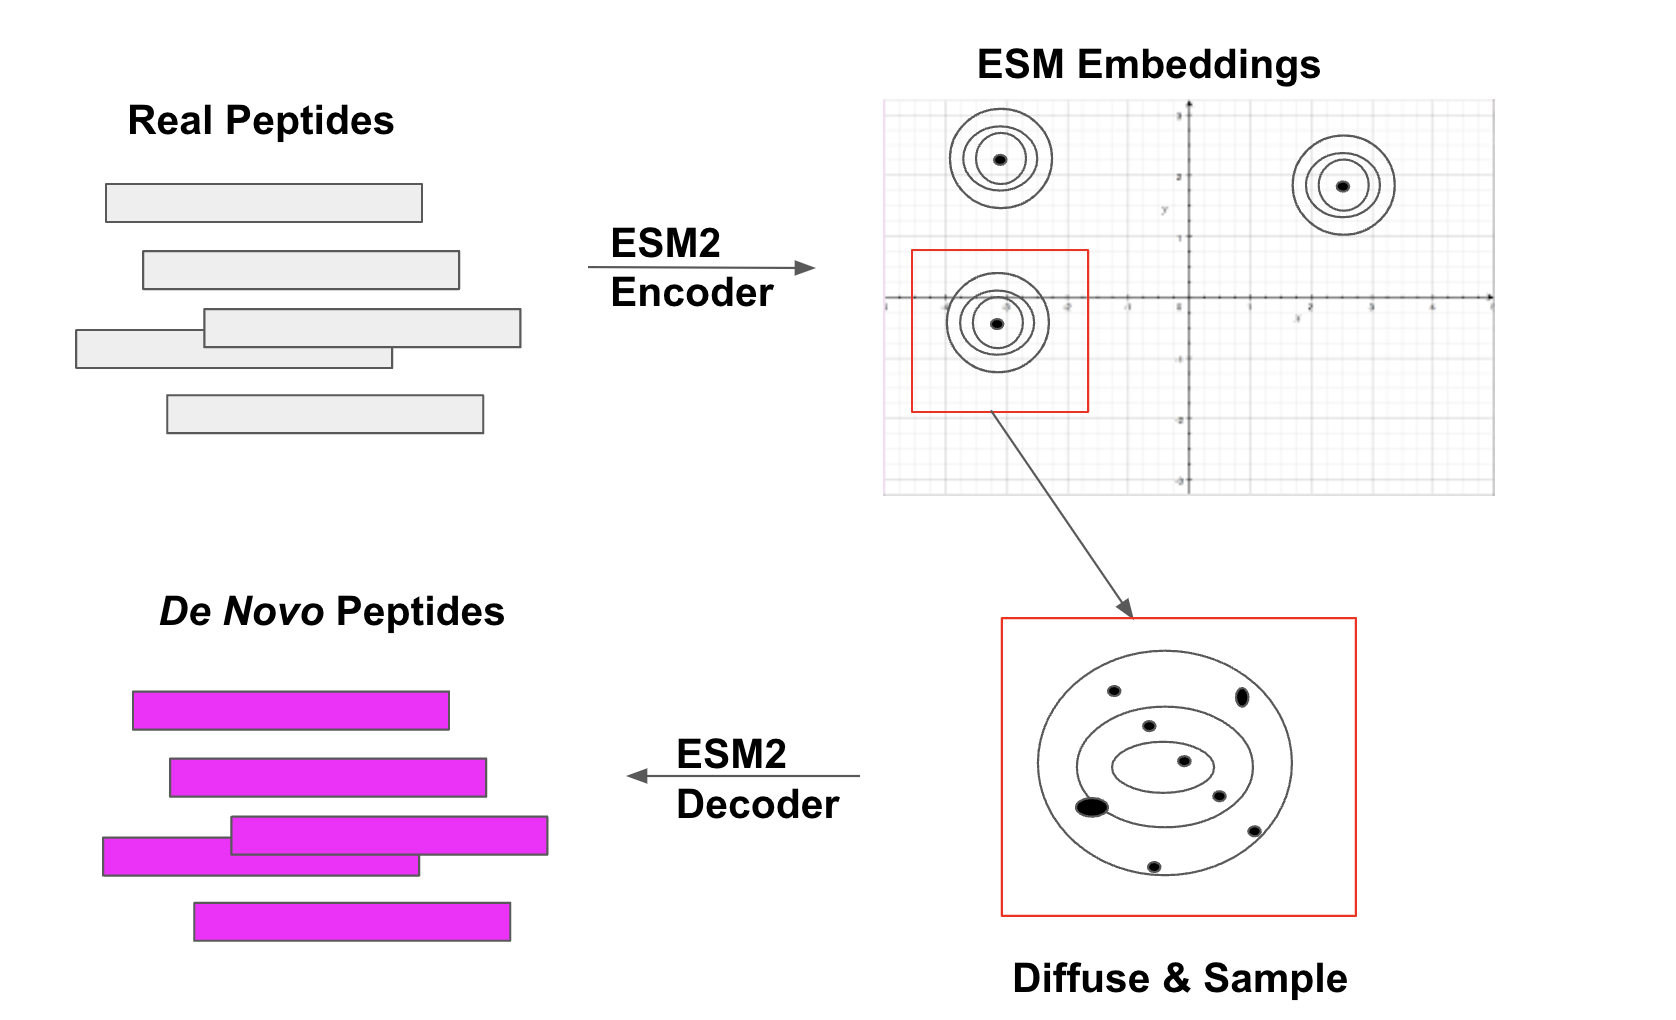

### Generation algorithm

We build a robust sampling algorithm, that should do a good job getting peptides from around a region. This creates de novo peptides that nonetheless look like naturally ocurring peptides.

In [8]:
def generate_peptides(min_length = 15, max_length = 18, n = 5000,\
                      num_base_peps = 100, df = noisy_df, sample_variances = range(5,22, 4)):

  base_peptides = df.loc[(df['pep_len'] <= max_length) & (df['pep_len'] >= min_length)].pep_seq.to_list()

  ##randomly sample 100 of these to use as base points
  sampled_peptides = random.sample(base_peptides, num_base_peps)

  ##embed with ESM, add random Gaussian noise on the order of
  #5, 9, 13, 17, and 21 standard deviations

  generated_peptides = []
  for pep in tqdm(sampled_peptides):
    ##GET ESM EMBEDDING
    target_seq = pep

    batch_labels, batch_strs, batch_tokens = batch_converter([("target_seq", target_seq)])
    batch_tokens = batch_tokens.cuda()
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    with torch.no_grad():
      results = model(batch_tokens, repr_layers=[33], return_contacts=False)

    token_representations = results["representations"][33].cpu()
    del batch_tokens

    num_samples_per_base = int(int(n / num_base_peps) / 5)

    for i in sample_variances:
      for j in range(num_samples_per_base):
        gen_pep = token_representations + torch.randn(token_representations.shape) * i * token_representations.var()
        aa_toks = list("ARNDCEQGHILKMFPSTWYV")
        aa_idxs = [alphabet.get_idx(aa) for aa in aa_toks]
        aa_logits = model.lm_head(gen_pep.cuda())[:, :, aa_idxs]
        predictions = torch.argmax(aa_logits, dim=2).tolist()[0]
        generated_pep_seq = "".join([aa_toks[i] for i in predictions])
        generated_peptides.append(generated_pep_seq[1:-1])

  return generated_peptides

## Loading up a CLIP model to do inference.

### Model

In [11]:
##create a lightning module that does a little clipping
##could do a decoder, or could skip it

class MiniCLIP(pl.LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        ##protein encoding: 2 layers, latent space of size 320?

        self.prot_embedder = nn.Sequential(
          nn.Linear(1280, 640),
          nn.ReLU(),
          nn.Linear(640, 320),
        )

        ##peptide encoding: start with 2 layers, may want to add in a decoder later
        self.pep_embedder = nn.Sequential(
          nn.Linear(1280, 640),
          nn.ReLU(),
          nn.Linear(640, 320),
        )

    def forward(self, pep_input, prot_input):
        ##get peptide and protein embeddings, dot together
        pep_embedding = F.normalize(self.pep_embedder(pep_input))
        prot_embedding = F.normalize(self.prot_embedder(prot_input))

        logits = torch.matmul(pep_embedding, prot_embedding.T) ##may need to transpose something here

        return logits

    def training_step(self, batch, batch_idx):

        logits = self(
            batch['peptide_input'],
            batch['protein_input'],
        )

        batch_size = batch['peptide_input'].shape[0]
        labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
                 ##this gives us the diagonal clip loss structure

        # loss of predicting partner using peptide
        partner_prediction_loss = F.cross_entropy(logits, labels)

        # loss of predicting peptide using partner
        peptide_prediction_loss = F.cross_entropy(logits.T, labels)

        loss = (partner_prediction_loss + peptide_prediction_loss) / 2

        self.log("train_loss", loss, sync_dist=True, batch_size=logits.shape[0])
        self.log("train_partner_prediction_loss", partner_prediction_loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0])
        self.log("train_peptide_prediction_loss", peptide_prediction_loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0])

        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        if dataloader_idx == 0 or dataloader_idx == 2:
          if dataloader_idx == 0:
            prefix = "noisy"
          else:
            prefix = "strict"

          # Predict on random batches of training batch size
          logits = self(
              batch['peptide_input'],
              batch['protein_input'],
          )

          batch_size = batch['peptide_input'].shape[0]
          labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
          ##this gives us the diagonal clip loss structure

          # loss of predicting partner using peptide
          partner_prediction_loss = F.cross_entropy(logits, labels)

          # loss of predicting peptide using partner
          peptide_prediction_loss = F.cross_entropy(logits.T, labels)

          loss = (partner_prediction_loss + peptide_prediction_loss) / 2


          # prediction of peptides for each partner
          peptide_predictions = logits.argmax(dim=0)
          # prediction of partners for each peptide
          partner_predictions = logits.argmax(dim=1)

          peptide_ranks = logits.argsort(dim=0).diag() + 1
          peptide_mrr = (peptide_ranks).float().pow(-1).mean()

          partner_ranks = logits.argsort(dim=1).diag() + 1
          partner_mrr = (partner_ranks).float().pow(-1).mean()

          partner_accuracy = partner_predictions.eq(labels).float().mean()
          peptide_accuracy = peptide_predictions.eq(labels).float().mean()

          k = int(logits.shape[0] / 10)
          peptide_topk_accuracy = torch.any((logits.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logits.shape[0]
          partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]


          self.log(f"{prefix}_val_loss", loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_perplexity", torch.exp(loss), sync_dist=False, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_partner_prediction_loss", partner_prediction_loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_peptide_prediction_loss", peptide_prediction_loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_partner_perplexity", torch.exp(partner_prediction_loss), sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_peptide_perplexity", torch.exp(peptide_prediction_loss), sync_dist=True, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_partner_accuracy", partner_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_peptide_accuracy", peptide_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_partner_top10p", partner_topk_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_peptide_top10p", peptide_topk_accuracy, sync_dist=True, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_peptide_mrr", peptide_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_val_partner_mrr", partner_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)

        else:
          if dataloader_idx == 1:
            prefix = "noisy"
          else:
            prefix = "strict"

          # Given a protein, predict the correct peptide out of 2
          logits = self(
              batch['peptide_input'],
              batch['protein_input'],
          )

          batch_size = batch['peptide_input'].shape[0]
          labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
          ##this gives us the diagonal clip loss structure


          binary_cross_entropy = F.cross_entropy(logits.T, labels)

          binary_predictions = logits.argmax(dim=0)
          binary_accuracy = binary_predictions.eq(labels).float().mean()

          self.log(f"{prefix}_binary_loss", binary_cross_entropy, sync_dist=True, prog_bar=False, batch_size=2, add_dataloader_idx=False)
          self.log(f"{prefix}_binary_accuracy", binary_accuracy, sync_dist=False, prog_bar=True, batch_size=2, add_dataloader_idx=False)


    def test_step(self, batch, batch_idx, dataloader_idx=0):

        if dataloader_idx == 0 or dataloader_idx == 2:
          if dataloader_idx == 0:
            prefix = "noisy"
          else:
            prefix = "strict"

          # Predict on random batches of training batch size
          logits = self(
              batch['peptide_input'],
              batch['protein_input'],
          )

          batch_size = batch['peptide_input'].shape[0]
          labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
          ##this gives us the diagonal clip loss structure

          # loss of predicting partner using peptide
          partner_prediction_loss = F.cross_entropy(logits, labels)

          # loss of predicting peptide using partner
          peptide_prediction_loss = F.cross_entropy(logits.T, labels)

          loss = (partner_prediction_loss + peptide_prediction_loss) / 2


          # prediction of peptides for each partner
          peptide_predictions = logits.argmax(dim=0)
          # prediction of partners for each peptide
          partner_predictions = logits.argmax(dim=1)

          peptide_ranks = logits.argsort(dim=0).diag() + 1
          peptide_mrr = (peptide_ranks).float().pow(-1).mean()

          partner_ranks = logits.argsort(dim=1).diag() + 1
          partner_mrr = (partner_ranks).float().pow(-1).mean()

          partner_accuracy = partner_predictions.eq(labels).float().mean()
          peptide_accuracy = peptide_predictions.eq(labels).float().mean()

          k = int(logits.shape[0] / 10)
          peptide_topk_accuracy = torch.any((logits.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logits.shape[0]
          partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]


          self.log(f"{prefix}_test_loss", loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_perplexity", torch.exp(loss), sync_dist=False, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_partner_prediction_loss", partner_prediction_loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_peptide_prediction_loss", peptide_prediction_loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_partner_perplexity", torch.exp(partner_prediction_loss), sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_peptide_perplexity", torch.exp(peptide_prediction_loss), sync_dist=True, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_partner_accuracy", partner_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_peptide_accuracy", peptide_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_partner_top10p", partner_topk_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_peptide_top10p", peptide_topk_accuracy, sync_dist=True, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_peptide_mrr", peptide_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log(f"{prefix}_test_partner_mrr", partner_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)

        else:
          if dataloader_idx == 1:
            prefix = "noisy"
          else:
            prefix = "strict"

          # Given a protein, predict the correct peptide out of 2
          logits = self(
              batch['peptide_input'],
              batch['protein_input'],
          )

          batch_size = batch['peptide_input'].shape[0]
          labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
          ##this gives us the diagonal clip loss structure


          binary_cross_entropy = F.cross_entropy(logits.T, labels)

          binary_predictions = logits.argmax(dim=0)
          binary_accuracy = binary_predictions.eq(labels).float().mean()

          self.log(f"{prefix}_test_binary_loss", binary_cross_entropy, sync_dist=True, prog_bar=False, batch_size=2, add_dataloader_idx=False)
          self.log(f"{prefix}_test_binary_accuracy", binary_accuracy, sync_dist=False, prog_bar=True, batch_size=2, add_dataloader_idx=False)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [12]:
##canonical model is canonical_miniclip_4-22-23.ckpt
miniclip = MiniCLIP.load_from_checkpoint("/content/drive/MyDrive/miniclip_data/canonical_miniclip_4-22-23.ckpt", lr = 0.003)
miniclip.eval()

MiniCLIP(
  (prot_embedder): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=320, bias=True)
  )
  (pep_embedder): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=320, bias=True)
  )
)

## Generator -> Discriminator: Putting it All Together

## Automated de Novo Peptide Generation

In [14]:
###Choosing parameters
##Number of peptides for each target
peps_per_target = 8


In [15]:
##sample targets
EWSFLI1 = 'MASTDYSTYSQAAAQQGYSAYTAQPTQGYAQTTQAYGQQSYGTYGQPTDVSYTQAQTTATYGQTAYATSYGQPPTGYTTPTAPQAYSQPVQGYGTGAYDTTTATVTTTQASYAAQSAYGTQPAYPAYGQQPAATAPTRPQDGNKPTETSQPQSSTGGYNQPSLGYGQSNYSYPQVPGSYPMQPVTAPPSYPPTSYSSTQPTSYDQSSYSQQNTYGQPSSYGQQSSYGQQSSYGQQPPTSYPPQTGSYSQAPSQYSQQSSSYGQQNPSYDSVRRGAWGNNMNSGLNKSPPLGGAQTISKNTEQRPQPDPYQILGPTSSRLANPGSGQIQLWQFLLELLSDSANASCITWEGTNGEFKMTDPDEVARRWGERKSKPNMNYDKLSRALRYYYDKNIMTKVHGKRYAYKFDFHGIAQALQPHPTESSMYKYPSDISYMPSYHAHQQKVNFVPPHPSSMPVTSSSFFGAASQYWTSPTGGIYPNPNVPRHPNTHVPSHLGSYY'
AMHR2 = 'MLGSLGLWALLPTAVEAPPNRRTCVFFEAPGVRGSTKTLGELLDTGTELPRAIRCLYSRCCFGIWNLTQDRAQVEMQGCRDSDEPGCESLHCDPSPRAHPSPGSTLFTCSCGTDFCNANYSHLPPPGSPGTPGSQGPQAAPGESIWMALVLLGLFLLLLLLLGSIILALLQRKNYRVRGEPVPEPRPDSGRDWSVELQELPELCFSQVIREGGHAVVWAGQLQGKLVAIKAFPPRSVAQFQAERALYELPGLQHDHIVRFITASRGGPGRLLSGPLLVLELHPKGSLCHYLTQYTSDWGSSLRMALSLAQGLAFLHEERWQNGQYKPGIAHRDLSSQNVLIREDGSCAIGDLGLALVLPGLTQPPAWTPTQPQGPAAIMEAGTQRYMAPELLDKTLDLQDWGMALRRADIYSLALLLWEILSRCPDLRPDSSPPPFQLAYEAELGNTPTSDELWALAVQERRRPYIPSTWRCFATDPDGLRELLEDCWDADPEARLTAECVQQRLAALAHPQESHPFPESCPRGCPPLCPEDCTSIPAPTILPCRPQRSACHFSVQQGPCSRNPQPACTLSPV'
FOXP3 ='MPNPRPGKPSAPSLALGPSPGASPSWRAAPKASDLLGARGPGGTFQGRDLRGGAHASSSSLNPMPPSQLQLPTLPLVMVAPSGARLGPLPHLQALLQDRPHFMHQLSTVDAHARTPVLQVHPLESPAMISLTPPTTATGVFSLKARPGLPPGINVASLEWVSREPALLCTFPNPSAPRKDSTLSAVPQSSYPLLANGVCKWPGCEKVFEEPEDFLKHCQADHLLDEKGRAQCLLQREMVQSLEQQLVLEKEKLSAMQAHLAGKMALTKASSVASSDKGSCCIVAAGSQGPVVPAWSGPREAPDSLFAVRRHLWGSHGNSTFPEFLHNMDYFKFHNMRPPFTYATLIRWAILEAPEKQRTLNEIYHWFTRMFAFFRNHPATWKNAIRHNLSLHKCFVRVESEKGAVWTVDELEFRKKRSQRPSRCSNPTPGP'
TRIM8 ='MAENWKNCFEEELICPICLHVFVEPVQLPCKHNFCRGCIGEAWAKDSGLVRCPECNQAYNQKPGLEKNLKLTNIVEKFNALHVEKPPAALHCVFCRRGPPLPAQKVCLRCEAPCCQSHVQTHLQQPSTARGHLLVEADDVRAWSCPQHNAYRLYHCEAEQVAVCQYCCYYSGAHQGHSVCDVEIRRNEIRKMLMKQQDRLEEREQDIEDQLYKLESDKRLVEEKVNQLKEEVRLQYEKLHQLLDEDLRQTVEVLDKAQAKFCSENAAQALHLGERMQEAKKLLGSLQLLFDKTEDVSFMKNTKSVKILMDRTQTCTSSSLSPTKIGHLNSKLFLNEVAKKEKQLRKMLEGPFSTPVPFLQSVPLYPCGVSSSGAEKRKHSTAFPEASFLETSSGPVGGQYGAAGTASGEGQSGQPLGPCSSTQHLVALPGGAQPVHSSPVFPPSQYPNGSAAQQPMLPQYGGRKILVCSVDNCYCSSVANHGGHQPYPRSGHFPWTVPSQEYSHPLPPTPSVPQSLPSLAVRDWLDASQQPGHQDFYRVYGQPSTKHYVTS'
Betacatenin = 'MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSLSGKGNPEEEDVDTSQVLYEWEQGFSQSFTQEQVADIDGQYAMTRAQRVRAAMFPETLDEGMQIPSTQFDAAHPTNVQRLAEPSQMLKHAVVNLINYQDDAELATRAIPELTKLLNDEDQVVVNKAAVMVHQLSKKEASRHAIMRSPQMVSAIVRTMQNTNDVETARCTAGTLHNLSHHREGLLAIFKSGGIPALVKMLGSPVDSVLFYAITTLHNLLLHQEGAKMAVRLAGGLQKMVALLNKTNVKFLAITTDCLQILAYGNQESKLIILASGGPQALVNIMRTYTYEKLLWTTSRVLKVLSVCSSNKPAIVEAGGMQALGLHLTDPSQRLVQNCLWTLRNLSDAATKQEGMEGLLGTLVQLLGSDDINVVTCAAGILSNLTCNNYKNKMMVCQVGGIEALVRTVLRAGDREDITEPAICALRHLTSRHQEAEMAQNAVRLHYGLPVVVKLLHPPSHWPLIKATVGLIRNLALCPANHAPLREQGAIPRLVQLLVRAHQDTQRRTSMGGTQQQFVEGVRMEEIVEGCTGALHILARDVHNRIVIRGLNTIPLFVQLLYSPIENIQRVAAGVLCELAQDKEAAEAIEAEGATAPLTELLHSRNEGVATYAAAVLFRMSEDKPQDYKKRLSVELTSSLFRTEPMAWNETADLGLDIGAQGEPLGYRQDDPSYRSFHSGGYGQDALGMDPMMEHEMGGHHPGADYPVDGLPDLGHAQDLMDGLPPGDSNQLAWFDTDL'
ETV6 = 'MSETPAQCSIKQERISYTPPESPVPSYASSTPLHVPVPRALRMEEDSIRLPAHLRLQPIYWSRDDVAQWLKWAENEFSLRPIDSNTFEMNGKALLLLTKEDFRYRSPHSGDVLYELLQHILKQRKPRILFSPFFHPGNSIHTQPEVILHQNHEEDNCVQRTPRPSVDNVHHNPPTIELLHRSRSPITTNHRPSPDPEQRPLRSPLDNMIRRLSPAERAQGPRPHQENNHQESYPLSVSPMENNHCPASSESHPKPSSPRQESTRVIQLMPSPIMHPLILNPRHSVDFKQSRLSEDGLHREGKPINLSHREDLAYMNHIMVSVSPPEEHAMPIGRIADCRLLWDYVYQLLSDSRYENFIRWEDKESKIFRIVDPNGLARLWGNHKNRTNMTYEKMSRALRHYYKLNIIRKEPGQRLLFRFMKTPDEIMSGRTDRLEHLESQELDEQIYQEDEC'
PAX3FOXO1 = 'MTTLAGAVPRMMRPGPGQNYPRSGFPLEVSTPLGQGRVNQLGGVFINGRPLPNHIRHKIVEMAHHGIRPCVISRQLRVSHGCVSKILCRYQETGSIRPGAIGGSKPKQVTTPDVEKKIEEYKRENPGMFSWEIRDKLLKDAVCDRNTVPSVSSISRILRSKFGKGEEEEADLERKEAEESEKKAKHSIDGILSERASAPQSDEGSDIDSEPDLPLKRKQRRSRTTFTAEQLEELERAFERTHYPDIYTREELAQRAKLTEARVQVWFSNRRARWRKQAGANQLMAFNHLIPGGFPPTAMPTLPTYQLSETSYQPTSIPQAVSDPSSTVHRPQPLPPSTVHQSTIPSNPDSSSAYCLPSTRHGFSSYTDSFVPPSGPSNPMNPTIGNGLSPQNSIRHNLSLHSKFIRVQNEGTGKSSWWMLNPEGGKSGKSPRRRAASMDNNSKFAKSRSRAAKKKASLQSGQEGAGDSPGSQFSKWPASPGSHSNDDFDNWSTFRPRTSSNASTISGRLSPIMTEQDDLGEGDVHSMVYPPSAAKMASTLPSLSEISNPENMENLLDNLNLLSSPTSLTVSTQSSPGTMMQQTPCYSFAPPNTSLNSPSPNYQKYTYGQSSMSPLPQMPIQTLQDNKSSYGGMSQYNCAPGLLKELLTSDSPPHNDIMTPVDPGVAQPNSRVLGQNVMMGPNSVMSTYGSQASHNKMMNPSSHTHPGHAQQTSAVNGRPLPHTVSTMPHTSGMNRLTQVKTPVQVPLPHPMQMSALGGYSSVSSCNGYGRMGLLHQEKLPSDLDGMFIERLDCDMESIIRNDLMDGDTLDFNFDNVLPNQSFPHSVKTTTHSWVSG'

targets = {'EWSFLI1':EWSFLI1,'AMHR2':AMHR2, 'FOXP3':FOXP3,'TRIM8':TRIM8,'Betacatenin':Betacatenin, 'ETV6':ETV6, 'PAX3FOXO1':PAX3FOXO1}


### Load up premade *de novo* peptides

In [16]:
###load up the canonical peptide dict, this is often much faster
with open("/content/drive/MyDrive/PepPrCLIP/data/canonical_100k_denovo_peptides.pkl", "rb") as f:
  candidate_peptide_dict = pickle.load(f)
all_candidate_peptides = list(candidate_peptide_dict.keys())


### run CLIP

In [23]:
##now, for each target, get the ESM embedding and clip it against the candidate peptide dictionary
output_dict = {}
for name, target_seq in tqdm(targets.items()):
  ##feed sequence it into ESM
  batch_labels, batch_strs, batch_tokens = batch_converter([("target_seq", target_seq)])
  batch_tokens = batch_tokens.cuda()
  batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

  with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)

  token_representations = results["representations"][33].cpu()
  del batch_tokens

  sequence_representations = []
  for j, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[j, 1 : tokens_len - 1].mean(0))

  target_prot_embedding = sequence_representations[0]

  peptide_scores = []
  seq_to_score_dict = {}

  for candidate_peptide, candidate_peptide_embedding in candidate_peptide_dict.items():
      score = miniclip.forward(candidate_peptide_embedding.unsqueeze(0), target_prot_embedding.unsqueeze(0))
      peptide_scores.append(score)
      seq_to_score_dict.update({candidate_peptide:score})

  topk_idxs = list(torch.concat(peptide_scores).argsort(dim=0, descending=True)[:peps_per_target])
  topk_peptides = [all_candidate_peptides[topk_idxs[i]] for i in range(len(topk_idxs))]
  topk_scores = [float(seq_to_score_dict[peptide]) for peptide in topk_peptides]

  output_dict.update({name:(topk_peptides, topk_scores)})


100%|██████████| 1/1 [00:47<00:00, 47.17s/it]


### Output as a CSV

In [24]:
##zipping up lists and converting them to a nice dataframe
peptides_df = pd.DataFrame(sum([list(zip([key + '_' + str(i) for i in range(peps_per_target)], output_dict[key][0], output_dict[key][1] ))\
 for key in output_dict.keys()], []), columns=['name', 'sequence', 'clip_score'])

In [25]:
peptides_df = peptides_df.sort_values('name')

In [26]:
today = date.today()
peptides_df.to_csv(f'peptides_{today}.csv')